Name: Miguel Mateo Osorio Vela, Matthew West

Development environment: Colab

# Programmatically Prompting LLMs for Tasks

- **Tasks:**
  1. Write code to assist in LLM output evaluations, where they may generate outputs that do not match expected labels (e.g., generating "Maybe" to a Yes or No question). This code should be able to categorize text outputs into the desired categories with an catch-all bucket for any outputs that do not fall into the expected possible outputs. Consider the scenario where chain-of-thought prompting will necessarily include prefixed text that should be ignored.
  2. Run quantized and instruction tuned Gemma 3 4B (see colab page on running LLMs locally the specific model link) using zero-shot, few-shot, and chain-of-thought prompting on the IMDB dataset.
  3. Compare LLM results against both the RNN and simple baseline.
  4. Discuss the observed results.

_Where it is relevant, make sure you follow deep learning best practices discussed in class. In particular, performing a hyperparameter search and setting up an proper train, dev, and test framework for evaluating hyperparameters and your final selected model._

- Evaluation scenarios:

  **Review Text Classification**
    - Use 2,000 examples for training (if needed) and 100 examples for testing (much smaller than deep learning because LLMs on CPU only are *very* slow).
    - Use zero-shot, few-shot (4 examples - 2 good, 2 bad), and chain-of-thought prompting
    - Ensure that prompts are formatted to give the LLM a good shot at succeeding (properly format Gemma 3 instructions and include appropriate system messages)
    - Plot a confusion matrix of the predictions.

- Discussion:  
  - Which setting of LLMs performs the best?
  - Which approach performs the best overall?
  - How much does LLM performance vary by prompting strategy?
  - What are the benefits and drawbacks of using LLMs for classification tasks such as movie review classification? *Cite specific evidence from this project.*

# IMDB Movie Review Dataset
Description from https://www.tensorflow.org/datasets/catalog/imdb_reviews:
> Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.

In [1]:
import tensorflow_datasets
import numpy as np

Load dataset

In [2]:
dataset, info = tensorflow_datasets.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.CTF0QX_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.CTF0QX_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.CTF0QX_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Get subset of the data for training and testing (2000 samples each). Convert Keras dataset to lists of strings and labels.

In [3]:
x_train = []
y_train = []

for sample, label in train_dataset.take(2000):
  x_train.append(sample.numpy())
  y_train.append(label.numpy())

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

print(x_train[0])
print(y_train[0])

x_test = []
y_test = []

for sample, label in test_dataset.take(100):
  x_test.append(sample.numpy())
  y_test.append(label.numpy())

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_test[0])
print(y_test[0])

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
0
b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of th

# Add your comparisons (baseline + RNN)

Here is the code for my comparison models from the deep learning part of the project.

# Run the experiments using Gemma and comparisons

Here is the code I used to get the results below! Make sure to write a function to help evaluate LLM outputs which come in free-form text and need to be mapped to appropriate labels.

# TASK 1: LLM output parser to 0 (negative) or 1 (positive)


In [4]:
import re

def parse_llm(llm_output) -> int:
    """
    Parses the text output from an LLM to extract a binary label, 0 (negative) or 1 (positive)

    This function handles this types of outputs:
    - Zero-shot
    - Few-shot
    - Chain-of-Thought (prioritize last occurrence of "positive" or negative)


    Returns:
        int:
            1  if the sentiment is determined to be 'Positive'.
            0  if the sentiment is determined to be 'Negative'.
            -1 if the output is ambiguous or fits the 'catch-all' bucket
               (neither label found).
    """

    # Normalize the output: tolowercase and strip whitespace
    text = str(llm_output).lower().strip()

    label_positive = "positive"
    label_negative = "negative"

    # Find the LAST occurrence of each label.
    # rfind() returns the highest index where the substring is found, or -1 if not found.
    idx_pos = text.rfind(label_positive)
    idx_neg = text.rfind(label_negative)

    if idx_pos == -1 and idx_neg == -1:
        # Catch-all bucket (Neither found)
        return -1

    if idx_pos > idx_neg:
        # "positive" appears after "negative"
        return 1
    else:
        # "negative" appears "positive"
        return 0

# ==========================================
# Testing the Parser with Scenarios
# ==========================================

# Scenario 1: Clean Zero-shot output
print(f"Test 1 (Clean Positive): {parse_llm('Positive')}")
# Expected: 1

# Scenario 2: Chain-of-Thought (Reasoning includes opposing word)
cot_example = "The movie had some positive moments, specifically the lighting, but overall the plot was boring. Therefore it is Negative."
print(f"Test 2 (CoT handling): {parse_llm(cot_example)}")
# Expected: 0 (Because 'Negative' appears last, overriding the earlier 'positive')

# Scenario 3: Ambiguous / Garbage output
garbage_example = "I am not sure what you mean. The movie was okay."
print(f"Test 3 (Catch-all): {parse_llm(garbage_example)}")
# Expected: -1 (Neither label found)

# Scenario 4: Case insensitivity and punctuation
messy_example = "   POSITIVE!!! "
print(f"Test 4 (Normalization): {parse_llm(messy_example)}")
# Expected: 1

Test 1 (Clean Positive): 1
Test 2 (CoT handling): 0
Test 3 (Catch-all): -1
Test 4 (Normalization): 1


# TASK 2: Prompting

In [5]:
# Uninstall the CPU version first to avoid conflicts
!pip uninstall -y llama-cpp-python

# Re-install with CUDA (GPU) support enabled
!CMAKE_ARGS="-DGGML_CUDA=on" pip install llama-cpp-python --force-reinstall --upgrade --no-cache-dir

# Install huggingface hub
!pip install huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 MB 111.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 299.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 263.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 307.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 134.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 267.8 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.16-cp312-cp312-linux_x86_64.whl size=49124205 sha256=9ee073c07c1c8533dfcfcf2959d2badd95cc29e026c5ab9e8a1626986933b634
  Stored in directory: /tmp/pip-ephem-wheel-cache-opkjl6le/wheels/90/82/ab/8784ee3fb99ddb07fd36a679ddbe63122cc07718f6c1eb3be8
Successfully built llama-cp

In [6]:
from google.colab import userdata
from huggingface_hub import login

# Login into Hugging Face Hub
hf_token = userdata.get('HF_TOKEN')
login(hf_token)

In [7]:

from huggingface_hub import hf_hub_download

instruct_model_name_or_path = "google/gemma-3-4b-it-qat-q4_0-gguf"
instruct_model_basename = "gemma-3-4b-it-q4_0.gguf" # INSTRUCT MODEL

instruct_model_path = hf_hub_download(repo_id=instruct_model_name_or_path, filename=instruct_model_basename)




gemma-3-4b-it-q4_0.gguf:   0%|          | 0.00/3.16G [00:00<?, ?B/s]

In [8]:
# Get a couple examples from the data
few_shot_examples_data = []
count_positive = 0
count_negative = 0
for i in range(10):
    if (count_positive < 2 and y_train[i] == 1):
      few_shot_examples_data.append((x_train[i], y_train[i]))
      count_positive += 1
    if (count_negative < 2 and y_train[i] == 0):
      few_shot_examples_data.append((x_train[i], y_train[i]))
      count_negative += 1
for i in range(4):
  print(few_shot_examples_data[i])

def get_chat_messages(strategy, review_text):

    # Check if the text is currently in bytes format ( b"This is bytes format")
    if isinstance(review_text, bytes):
        # If true, decode it into a standard string ("Hello world")
        review_text = review_text.decode('utf-8')
    else:
        # If false (it's already a string), keep it exactly as it is
        review_text = review_text

    base_instruction = (
        "You are a movie review sentiment classifier. "
        "Classify the following review as either 'positive' or 'negative'. "
        "Do not output anything else."
    )

    messages = []

    if strategy == "zero_shot":
        messages = [
            {"role": "user", "content": f"{base_instruction}\n\nReview: {review_text}\nSentiment:"}
        ]

    elif strategy == "cot":
        messages = [
            {"role": "user", "content": (
                f"{base_instruction}\n\n"
                f"Review: {review_text}\n"
                "Let's think step by step to determine the sentiment. "
                "Finally, conclude with 'Therefore, the sentiment is [positive/negative]'."
            )}
        ]

    elif strategy == "few_shot":

        messages.append({"role": "system", "content": base_instruction})

        # Add the 4 examples as a conversation history

        for ex_text, ex_label in few_shot_examples_data:
            # Decode the example text if it is bytes
            if isinstance(ex_text, bytes):
                ex_text = ex_text.decode('utf-8')

            label_str = "positive" if ex_label == 1 else "negative"
            messages.append({"role": "user", "content": f"Review: {ex_text}\nSentiment:"})
            messages.append({"role": "assistant", "content": label_str})

        # Finally, add the target review
        messages.append({"role": "user", "content": f"Review: {review_text}\nSentiment:"})

    return messages

(np.bytes_(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."), np.int64(0))
(np.bytes_(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film 

In [9]:
from tqdm import tqdm # for progress bar
import sklearn.metrics

def evaluate_model_llama(strategy, x_data, y_true, limit=100):
    predictions = []
    ground_truth = []

    print(f"Running evaluation for strategy: {strategy}...")

    # Set max_tokens depending prompting strategy
    # Chain of thought needs space to think, others just need a single word.
    if strategy == "cot":
        current_max_tokens = 128
    else:
        current_max_tokens = 8

    # loop through all tests
    for i in tqdm(range(limit)):
        review = x_data[i]
        label = y_true[i]

        messages = get_chat_messages(strategy, review)

        try:

            response = llm.create_chat_completion(
                messages=messages,
                max_tokens=current_max_tokens,
                temperature=0.01, # low temperature to enhance consistency, we dont want the model to be creative, we want deterministic outputs
                top_p=0.95 # nucleous sampling so the model doesnt choose random least likely words(hallucinations)
            )

            generated_text = response['choices'][0]['message']['content']

            # Parse sentiment using pre_defined function
            pred_label = parse_llm(generated_text)

            # Handle invalid outputs
            if pred_label == -1:
                # If parsing fails, we mark it as wrong to be strict
                pred_label = 1 - label

            predictions.append(pred_label)
            ground_truth.append(label)

        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            # Ensure we still record a prediction (failure) so lists stay aligned
            predictions.append(1 - label)
            ground_truth.append(label)

    acc = sklearn.metrics.accuracy_score(ground_truth, predictions)
    cm = sklearn.metrics.confusion_matrix(ground_truth, predictions)

    print(f"Accuracy for {strategy}: {acc:.2f}")
    return acc, cm


In [10]:
from llama_cpp import Llama

llm = Llama(
    model_path=instruct_model_path,
    n_threads=2, # CPU cores
    n_ctx=4096, # Context window size is increased from 512 to 4096 to fit the 4 examples in few_shot strategy
    n_gpu_layers=-1
    )


ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    no
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: NVIDIA L4, compute capability 8.9, VMM: yes
llama_model_load_from_file_impl: using device CUDA0 (NVIDIA L4) - 22501 MiB free
llama_model_loader: loaded meta data with 39 key-value pairs and 444 tensors from /root/.cache/huggingface/hub/models--google--gemma-3-4b-it-qat-q4_0-gguf/snapshots/15f73f5eee9c28f53afefef5723e29680c2fc78a/gemma-3-4b-it-q4_0.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = gemma3
llama_model_loader: - kv   1:                      gemma3.context_length u32              = 131072
llama_model_loader: - kv   2:                         gemma3.block_count u32              = 34
llama_model_loader: - kv   3:                    gemma3.embedding_length u32              =

In [11]:
# Notice that we have no layers on the GPU
print("GPU Layers")
print(llm.model_params.n_gpu_layers)
print("CPU Layers")
from llama_cpp import llama_n_layer
print(llama_n_layer(llm.model))


GPU Layers
2147483647
CPU Layers
34


In [12]:
# Run the experiments
acc_zero, cm_zero = evaluate_model_llama("zero_shot", x_test, y_test)
acc_few, cm_few = evaluate_model_llama("few_shot", x_test, y_test)
acc_cot, cm_cot = evaluate_model_llama("cot", x_test, y_test)

Running evaluation for strategy: zero_shot...


  0%|          | 0/100 [00:00<?, ?it/s]llama_perf_context_print:        load time =     349.08 ms
llama_perf_context_print: prompt eval time =     348.61 ms /   281 tokens (    1.24 ms per token,   806.06 tokens per second)
llama_perf_context_print:        eval time =      39.92 ms /     2 runs   (   19.96 ms per token,    50.10 tokens per second)
llama_perf_context_print:       total time =     398.44 ms /   283 tokens
llama_perf_context_print:    graphs reused =          1
  1%|          | 1/100 [00:00<00:39,  2.48it/s]Llama.generate: 35 prefix-match hit, remaining 385 prompt tokens to eval
llama_perf_context_print:        load time =     349.08 ms
llama_perf_context_print: prompt eval time =      72.72 ms /   385 tokens (    0.19 ms per token,  5294.64 tokens per second)
llama_perf_context_print:        eval time =      36.15 ms /     2 runs   (   18.08 ms per token,    55.32 tokens per second)
llama_perf_context_print:       total time =     117.51 ms /   387 tokens
llama_perf_cont

Accuracy for zero_shot: 0.87
Running evaluation for strategy: few_shot...


  0%|          | 0/100 [00:00<?, ?it/s]Llama.generate: 32 prefix-match hit, remaining 784 prompt tokens to eval
llama_perf_context_print:        load time =     349.08 ms
llama_perf_context_print: prompt eval time =     160.84 ms /   784 tokens (    0.21 ms per token,  4874.29 tokens per second)
llama_perf_context_print:        eval time =      20.43 ms /     1 runs   (   20.43 ms per token,    48.95 tokens per second)
llama_perf_context_print:       total time =     186.84 ms /   785 tokens
llama_perf_context_print:    graphs reused =          0
  1%|          | 1/100 [00:00<00:19,  5.17it/s]Llama.generate: 570 prefix-match hit, remaining 385 prompt tokens to eval
llama_perf_context_print:        load time =     349.08 ms
llama_perf_context_print: prompt eval time =      86.51 ms /   385 tokens (    0.22 ms per token,  4450.46 tokens per second)
llama_perf_context_print:        eval time =      20.79 ms /     1 runs   (   20.79 ms per token,    48.11 tokens per second)
llama_perf_cont

Accuracy for few_shot: 0.84
Running evaluation for strategy: cot...


  0%|          | 0/100 [00:00<?, ?it/s]Llama.generate: 32 prefix-match hit, remaining 275 prompt tokens to eval
llama_perf_context_print:        load time =     349.08 ms
llama_perf_context_print: prompt eval time =      55.37 ms /   275 tokens (    0.20 ms per token,  4966.77 tokens per second)
llama_perf_context_print:        eval time =      35.40 ms /     2 runs   (   17.70 ms per token,    56.49 tokens per second)
llama_perf_context_print:       total time =      98.42 ms /   277 tokens
llama_perf_context_print:    graphs reused =          1
  1%|          | 1/100 [00:00<00:10,  9.73it/s]Llama.generate: 35 prefix-match hit, remaining 411 prompt tokens to eval
llama_perf_context_print:        load time =     349.08 ms
llama_perf_context_print: prompt eval time =      82.30 ms /   411 tokens (    0.20 ms per token,  4994.23 tokens per second)
llama_perf_context_print:        eval time =     995.80 ms /    64 runs   (   15.56 ms per token,    64.27 tokens per second)
llama_perf_conte

Accuracy for cot: 0.85


# Report your results

Check these amazing plots & discussion.

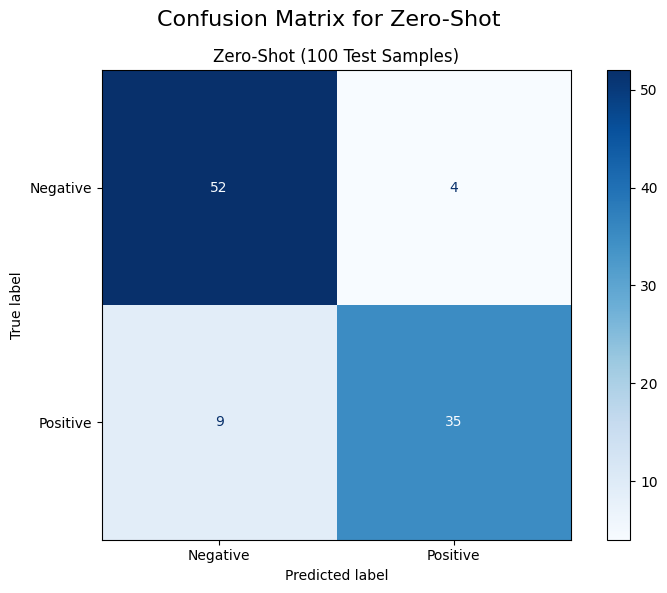

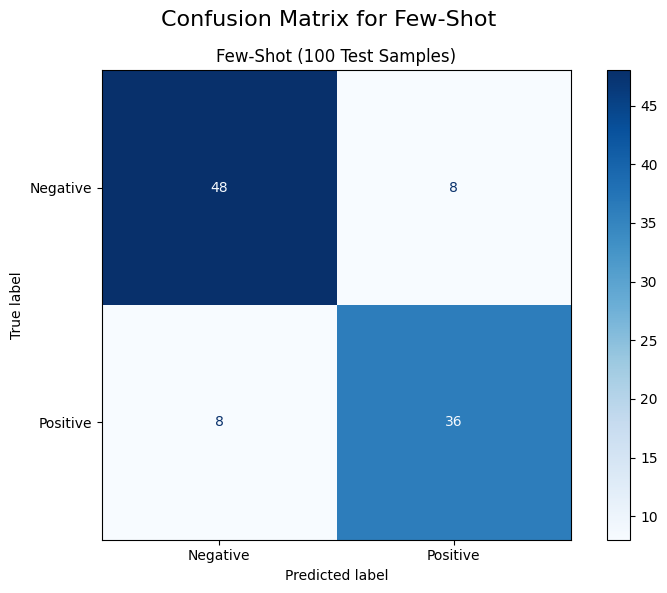

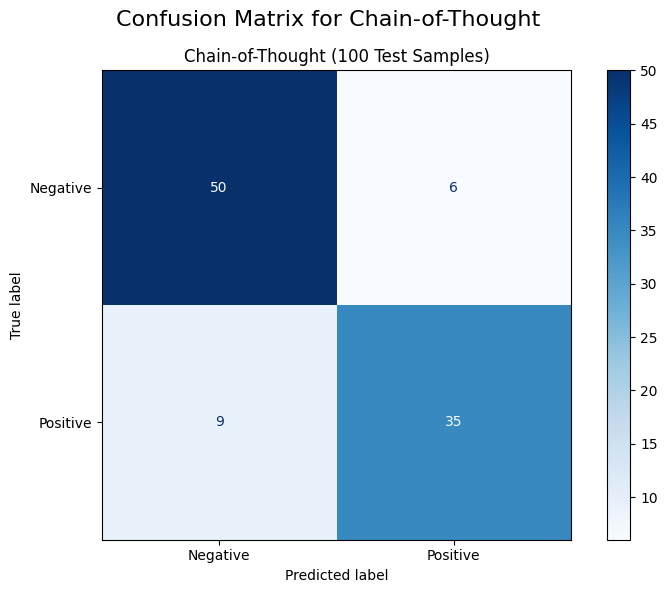

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

results = {
    'Zero-Shot': cm_zero,
    'Few-Shot': cm_few,
    'Chain-of-Thought': cm_cot
}

labels = ['Zero-Shot', 'Few-Shot', 'Chain-of-Thought']

for label in labels:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    fig.suptitle(f"Confusion Matrix for {label}", fontsize=16)

    # Get the pre-calculated confusion matrix
    cm = results[label]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

    # Plotting
    disp.plot(cmap='Blues', ax=ax, colorbar=True)
    ax.set_title(f"{label} (100 Test Samples)")

    plt.tight_layout()
    plt.show()

# COMPARISON WITH BASELINE AND RNN


# DISCUSSION